## Libraries

In [1]:
#import packages for analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib.lines import Line2D
from numpy import log10
import numpy as np
import matplotlib.patches as mpatches
import scipy.stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score 
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
from gnat import misc_utils
from gnat import error_calculator
from gnat import rarefaction
from gnat import gtf_tools
from gnat import kegg_tools

## Functions

In [2]:
#A function to get this info parsed to the form I want
def parse_distance_data(distance_matrix):
    #redefine dataframe to perserve origional dataframe
    matrix = distance_matrix
    
    #add plant and comparison metadata
    transition = []
    plant = []
    
    comparison1_values = list(matrix["comp1"])
    comparison2_values = list(matrix["comp2"])
    
    for i in range(len(comparison1_values)):
        sample1_id = comparison1_values[i]
        sample2_id = comparison2_values[i]
        
        if sample1_id[6] == sample2_id[6]:
            #define comparisons
            if sample1_id[5] == '3' and sample2_id[5] == '5' or sample1_id[5] == '5' and sample2_id[5] == '3':
                transition.append('3rd-instar : 5th-instar')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            elif sample1_id[5] == '5' and sample2_id[5] == 'E' or sample1_id[5] == 'E' and sample2_id[5] == '5':
                transition.append('5th-instar : Early-pupa')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            elif sample1_id[5] == 'E' and sample2_id[5] == 'L' or sample1_id[5] == 'L' and sample2_id[5] == 'E':
                transition.append('Early-pupa : Late-pupa')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            elif sample1_id[5] == 'L' and sample2_id[5] == 'A' or sample1_id[5] == 'A' and sample2_id[5] == 'L':
                transition.append('Late-pupa : Adult')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            else:
                transition.append('NA')
                plant.append('NA')         
        else:
            transition.append('NA')
            plant.append('NA')

    
    #add comparisons to dataframe
    matrix['transition'] = transition
    matrix['plant'] = plant
    
    #remove na values
    matrix = matrix.loc[matrix['transition'] != 'NA']
    
    #sort data by transition order
    transitions = ['3rd-instar : 5th-instar', '5th-instar : Early-pupa', 'Early-pupa : Late-pupa', 'Late-pupa : Adult']
    matrix['transition'] = pd.Categorical(matrix['transition'], categories = transitions)
    matrix = matrix.sort_values(by='transition')
    
    return matrix

#A function to parse for specific data
def parse_distance_data_specific(distance_matrix):
    #redefine dataframe to perserve origional dataframe
    matrix = distance_matrix
    
    #add plant and comparison metadata
    transition = []
    plant = []
    
    comparison1_values = list(matrix["comp1"])
    comparison2_values = list(matrix["comp2"])
    
    for i in range(len(comparison1_values)):
        sample1_id = comparison1_values[i]
        sample2_id = comparison2_values[i]
        
        if sample1_id[6] == sample2_id[6]:
            #define comparisons
            if sample1_id[5] == '3' and sample2_id[5] == 'A' or sample1_id[5] == 'A' and sample2_id[5] == '3':
                transition.append('3rd-instar : Adult')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
                    
            elif sample1_id[5] == '5' and sample2_id[5] == 'A' or sample1_id[5] == 'A' and sample2_id[5] == '5':
                transition.append('5th-instar : Adult')
                if sample1_id[6] == 'c':
                    plant.append('A. curassavica')
                elif sample1_id[6] == 'i':
                    plant.append('A. incarnata')
            else:
                transition.append('NA')
                plant.append('NA')         
        else:
            transition.append('NA')
            plant.append('NA')

    
    #add comparisons to dataframe
    matrix['transition'] = transition
    matrix['plant'] = plant
    
    #remove na values
    matrix = matrix.loc[matrix['transition'] != 'NA']
    
    return matrix

#A function to load differential expression data
def load_de_data(file):
    #read data
    df = pd.read_csv(file, index_col=0)
    #add column for significantly up or down
    df["regulation"] = df["FDR"]
    #if FDR is less than cutoff and logFC is greater than 0, regulation = up
    df.loc[(df['FDR'] <= 0.01) & (df['logFC'] > 0), 'regulation'] = 'up'
    #if FDR is less than cutoff and logFC is less than 0, regulation = down
    df.loc[(df['FDR'] <= 0.01) & (df['logFC'] < 0), 'regulation'] = 'down'
    #if FDR is greater than cutoff, regulation = NA
    df.loc[df['FDR'] > 0.01, 'regulation'] = 'NA'
    
    return df

#A function to get this info parsed to the form I want
def parse_distance_data_plantcomp(distance_matrix):
    #redefine dataframe to perserve origional dataframe
    matrix = distance_matrix
    
    #add plant and comparison metadata
    stage = []
    plant_comp = []
    
    comparison1_values = list(matrix["comp1"])
    comparison2_values = list(matrix["comp2"])
    
    for i in range(len(comparison1_values)):
        sample1_id = comparison1_values[i]
        sample2_id = comparison2_values[i]
        
        #only get comparisons that are comparing the same stage
        if sample1_id[5] == sample2_id[5]:
            #add stage
            if sample1_id[5] == '3':
                stage.append('third-instar')
            elif sample1_id[5] == '5':
                stage.append('fifth-instar')
            elif sample1_id[5] == 'E':
                stage.append('early-pupa')
            elif sample1_id[5] == 'L':
                stage.append('late-pupa')
            elif sample1_id[5] == 'A':
                stage.append('adult')
            else:
                print(sample1_id[5])
            #define plant comparisons
            if sample1_id[6] == 'c' and sample2_id[6] == 'i' or sample1_id[6] == 'i' and sample2_id[6] == 'c':
                plant_comp.append('A. incarnata : A. curassavica')
                
            elif sample1_id[6] == 'c' and sample2_id[6] == 'c':
                plant_comp.append('A. curassavica : A. curassavica')
                
            elif sample1_id[6] == 'i' and sample2_id[6] == 'i':
                plant_comp.append('A. incarnata : A. incarnata')
                     
        else:
            stage.append('NA')
            plant_comp.append('NA')

    
    #add comparisons to dataframe
    matrix['plant'] = plant_comp
    matrix['stage'] = stage
    
    #remove na values
    matrix = matrix.loc[matrix['plant'] != 'NA']
    
    #sort data by transition order
    stages = ['third-instar', 'fifth-instar', 'early-pupa', 'late-pupa', 'adult']
    matrix['stage'] = pd.Categorical(matrix['stage'], categories = stages)
    matrix = matrix.sort_values(by='stage')
    
    return matrix

## Data Loading

In [3]:
# load data and analysis metadata
data = pd.read_csv('/home/gabe/Desktop/mtstp/data/intermediate_data/count_tables/dpl_tpm_counts_kallisto.csv')
data.rename(columns={data.columns[0]: "sample-id" }, inplace = True)
metadata = pd.read_csv('/home/gabe/Desktop/mtstp/data/experiment_metadata/mtstp_analysis_metadata.tsv', sep="\t")

#since this analysis will onyl deal with uninfected individuals, I'll filter out all infected samples
uninfected_samples = list(metadata.loc[metadata['infection-status'] != 'infected']['sample-id'])
uninfected_data = data[data['sample-id'].isin(uninfected_samples)]
uninfected_data.set_index("sample-id", inplace = True)

In [9]:
uninfected_data

,lcl|KZ248545.1_cds_OWR45966.1_1,lcl|KZ248545.1_cds_OWR42929.1_2,lcl|KZ248545.1_cds_OWR42930.1_3,lcl|KZ248545.1_cds_OWR42931.1_4,lcl|KZ248545.1_cds_OWR42932.1_5,lcl|KZ248545.1_cds_OWR42933.1_6,lcl|KZ248545.1_cds_OWR42934.1_7,lcl|KZ248545.1_cds_OWR42935.1_8,lcl|KZ248545.1_cds_OWR42936.1_9,lcl|KZ248545.1_cds_OWR51149.1_10,...,lcl|KZ253939.1_cds_OWR46811.1_15223,lcl|KZ253939.1_cds_OWR46812.1_15224,lcl|KZ253939.1_cds_OWR46813.1_15225,lcl|KZ253939.1_cds_OWR46814.1_15226,lcl|KZ253939.1_cds_OWR46815.1_15227,lcl|KZ253939.1_cds_OWR48030.1_15228,lcl|KZ253939.1_cds_OWR48031.1_15229,lcl|KZ253939.1_cds_OWR48032.1_15230,lcl|KZ253939.1_cds_OWR48033.1_15231,lcl|KZ253939.1_cds_OWR55584.1_15232
sample-id,,,,,,,,,,,,,,,,,,,,,
mtstp5iu98,40.307900,56.571700,1108.7200,161.260000,3.714120,1.121030,0.000000,4.427440,80.614100,0.571328,...,7.63375,8.38529,5.12428,1.773930,0.788076,0.011144,21.51140,25.0025,0.000000,0.857986
mtstp3cu2,117.197000,158.977000,473.1770,50.214300,51.896000,1.055150,0.024980,3.666070,47.019600,1.520990,...,15.86870,12.53940,48.76550,3.593860,1.226600,0.291278,29.57810,105.5880,0.000000,8.049470
mtstp5cu17,53.580300,72.488100,847.3960,143.629000,6.129130,0.000000,0.000000,1.789000,68.445200,1.173910,...,8.82507,8.81382,4.24864,0.897578,0.765841,0.000000,31.69200,76.7036,0.000000,2.985790
mtstpLiu130,0.036026,0.000000,750.5200,3.536750,3.418260,0.629009,0.000000,0.529960,1.137820,11.142000,...,13.34150,5.86868,133.43200,1.111620,1.160870,0.006044,55.27390,130.0230,0.000000,0.239330
mtstpLiu133,0.025680,0.091779,439.9790,8.929790,2.229130,2.650270,1.432950,2.357130,0.270234,8.235870,...,11.09360,5.79064,146.81100,1.351020,1.207460,0.025850,38.63890,70.4854,0.000000,0.000000
mtstpEcu38,0.000000,0.011409,205.2790,0.678483,4.695950,0.953417,0.020652,0.044239,0.000000,6.483220,...,9.24495,12.27980,355.74000,3.540060,1.861930,0.008570,44.80340,223.3030,0.717028,2.056850
mtstpAiu148,20.759100,32.852500,879.6510,6.046150,6.695500,0.369350,0.351016,5.922370,4.350970,66.263500,...,34.54550,4.44715,39.52500,1.589870,1.345300,0.131708,23.62360,65.2631,0.000000,0.374311
mtstp5iu100,32.551700,40.219300,1100.9300,173.425000,5.561670,1.156950,0.000000,2.484970,86.955500,1.052060,...,9.33069,8.27777,9.11512,1.463130,0.947899,0.000000,26.54300,54.4123,0.000000,0.933983
mtstpLiu131,1.578640,1.649300,1298.7200,9.646060,0.334944,0.417812,0.834579,7.058230,2.366580,19.060900,...,21.34560,2.39756,138.19300,0.970659,0.904959,0.000000,16.73580,79.4092,0.000000,0.106698


In [7]:
metadata

,sample-id,plant,infection-status,developmental-stage,lineage
0,mtstp3ci10,curassavica,infected,third-instar,EJ
1,mtstp3ci11,curassavica,infected,third-instar,EJ
2,mtstp3ci12,curassavica,infected,third-instar,AT
3,mtstp3ci13,curassavica,infected,third-instar,AT
4,mtstp3ci9,curassavica,infected,third-instar,EJ
...,...,...,...,...,...
91,mtstpLiu129,incarnata,uninfected,late-pupa,EJ
92,mtstpLiu130,incarnata,uninfected,late-pupa,EJ
93,mtstpLiu131,incarnata,uninfected,late-pupa,EJ
94,mtstpLiu133,incarnata,uninfected,late-pupa,AT


## Clustering across developmental stages

To examine how transcriptionally distinct each stage is, I performed a principle component analysis using Manhattan distances. I used the following script:

    manhattan_pca.R

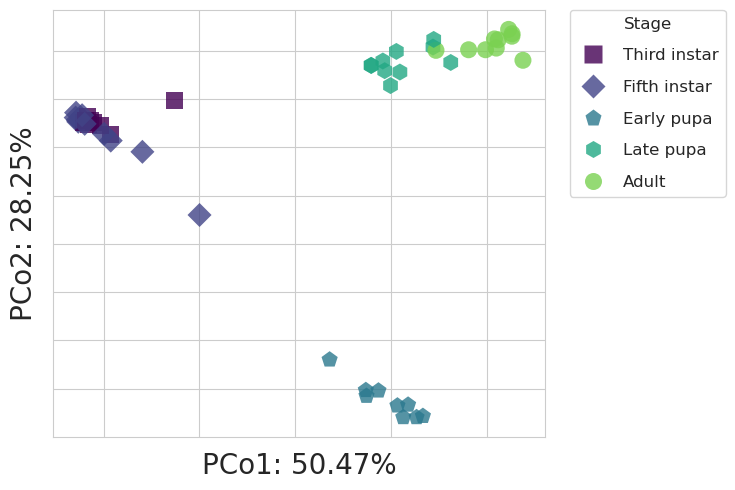

In [6]:
manhattan_distance_matrix = pd.read_csv('/home/gabe/Desktop/mtstp/data/intermediate_data/distance_matricies/manhattan.csv', index_col=0)
#remove infected samples
for sample in list(manhattan_distance_matrix):
    if sample[7] == 'i':
        manhattan_distance_matrix.drop(labels=sample, axis=0, inplace=True)
        manhattan_distance_matrix.drop(labels=sample, axis=1, inplace=True)

#and now to load and plot the data
manhattan_pca_data = pd.read_csv('/home/gabe/Desktop/mtstp/data/intermediate_data/pca/manhattan_uninfected_pca.csv', index_col=0)[["PC1", "PC2"]]
#add metadata data
stage = []
plant = []

for sample in list(manhattan_pca_data.index):
    if sample[5] == '3':
        stage.append('third-instar')
    elif sample[5] == '5':
        stage.append('fifth-instar')
    elif sample[5] == 'E':
        stage.append('early-pupa')
    elif sample[5] == 'L':
        stage.append('late-pupa')
    elif sample[5] == 'A':
        stage.append('adult')

    if sample[6] == 'i':
        plant.append('A. incarnata')
    elif sample[6] == 'c':
        plant.append('A. curassavica')
        
manhattan_pca_data['developmental-stage'] = stage
manhattan_pca_data['plant'] = plant

#and now to plot
sns.set_style("whitegrid")
#define color palette
# Get the "Spectral" colormap
cmap = plt.cm.get_cmap('viridis')

# Divide the colormap into 14 bins
num_bins = 5
colors = [cmap(i / num_bins) for i in range(num_bins)]
# Extract hex codes
colors = [mcolors.to_hex(color) for color in colors]
#make palette
custom_palette = sns.color_palette(colors)
sns.set_palette(custom_palette)

fig, ax1 = plt.subplots(1, 1, figsize=(7.5, 5))
hue_order = ['third-instar', 'fifth-instar', 'early-pupa', 'late-pupa', 'adult']
manhattan_pca_plot = sns.scatterplot(data=manhattan_pca_data, x='PC1', y='PC2', ax=ax1, hue='developmental-stage', 
                style='developmental-stage', hue_order = hue_order,
                s=150, alpha=0.8, edgecolor = 'none', markers=['D', 's', 'h', 'p', 'o'])

ax1.set_xlabel('PCo1: 50.47%', size=20)
ax1.set_ylabel('PCo2: 28.25%', size=20)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

handles, previous_labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, 
           labels=['Third instar', 'Fifth instar', 'Early pupa', 'Late pupa', 'Adult'],
          bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12, title="Stage", 
           title_fontsize = 12, labelspacing = 1)

#ax1.set_title("Manhattan Distance")
plt.tight_layout()
plt.savefig('/home/gabe/Desktop/mtstp/figures/primary/manhattan_pca.pdf')

## Distance comparisons across development

It looks like the vast majority of differences are explained by ontogeny, so I'll start with quantifying that more first.

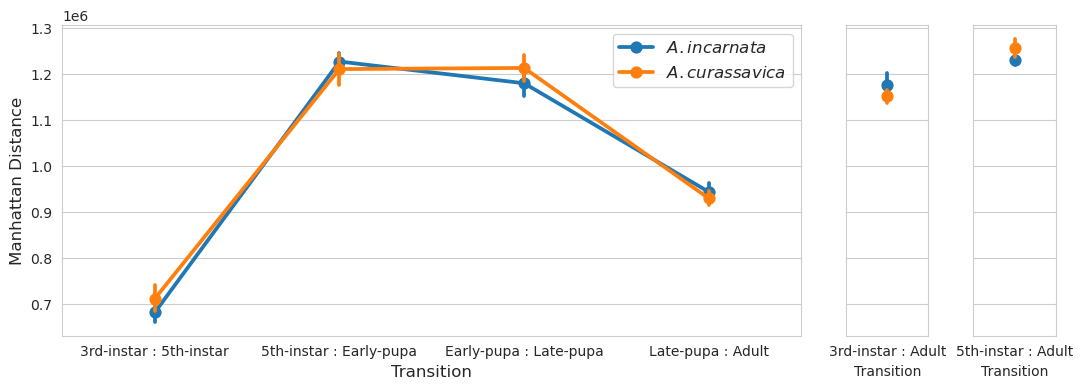

In [7]:
#I want to ignore warnings for plotting. If it works it works
import warnings
warnings.filterwarnings('ignore')

#convert data to long format
manhattan_matrix_long = manhattan_distance_matrix.stack().reset_index()
manhattan_matrix_long.columns = ['comp1', 'comp2', 'manhattan_distance']
manhattan_matrix_long = manhattan_matrix_long[manhattan_matrix_long['comp1'] != manhattan_matrix_long['comp2']]
#parse comparisons
manhattan_data = parse_distance_data(manhattan_matrix_long)

manhattan_data_l_a = parse_distance_data_specific(manhattan_matrix_long)

sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 3, figsize=(11, 4), gridspec_kw={'width_ratios': [9, 1, 1]}, sharey=True)

sns.pointplot(data=manhattan_data, y="manhattan_distance", x="transition", hue="plant", ax=ax[0])
ax1_legend=ax[0].legend(prop=fm.FontProperties(size=12))
ax1_legend.get_texts()[1].set_text('$A. curassavica$')
ax1_legend.get_texts()[0].set_text('$A. incarnata$')
ax[0].set_ylabel('Manhattan Distance', size=12)
ax[0].set_xlabel('Transition', size=12)

sns.pointplot(data=manhattan_data_l_a.loc[manhattan_data_l_a['transition'] == '3rd-instar : Adult'], y="manhattan_distance", x="transition", hue="plant", ax=ax[1], legend=False)
ax[1].set_ylabel('')
ax[1].set_xlabel('Transition')

sns.pointplot(data=manhattan_data_l_a.loc[manhattan_data_l_a['transition'] == '5th-instar : Adult'], y="manhattan_distance", x="transition", hue="plant", ax=ax[2], legend=False)
ax[2].set_ylabel('')
ax[2].set_xlabel('Transition')

plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
plt.savefig('/home/gabe/Desktop/mtstp/figures/manhattan_distance_pointplot.pdf')

In [23]:
#print mean distance for each adjacent comparison
for transition in list(set(list(manhattan_data['transition']))):
    distances = list(manhattan_data.loc[manhattan_data['transition'] == transition]['manhattan_distance'])
    average_dist = sum(distances) / len(distances)
    avg_dist_scientific_notation = "{:e}".format(average_dist)
    print(f'Transition: {transition}\tAverage Manhattan distance: {avg_dist_scientific_notation}')

Transition: Early-pupa : Late-pupa	Average Manhattan distance: 1.196854e+06
Transition: Late-pupa : Adult	Average Manhattan distance: 9.372581e+05
Transition: 5th-instar : Early-pupa	Average Manhattan distance: 1.219216e+06
Transition: 3rd-instar : 5th-instar	Average Manhattan distance: 6.973189e+05


In [34]:
#print distances from larvae to pupae
third_to_adult_dists = list(manhattan_data_l_a.loc[manhattan_data_l_a['transition'] == '3rd-instar : Adult']['manhattan_distance'])
third_to_adult_mean_dists = sum(third_to_adult_dists) / len(third_to_adult_dists)

fifth_to_adult_dists = list(manhattan_data_l_a.loc[manhattan_data_l_a['transition'] == '5th-instar : Adult']['manhattan_distance'])
fifth_to_adult_mean_dists = sum(fifth_to_adult_dists) / len(fifth_to_adult_dists)

print(f'Transition: 3rd-instar : Adult\tAverage Manhattan distance: {third_to_adult_mean_dists}')
print(f'Transition: 5th-instar : Adult\tAverage Manhattan distance: {fifth_to_adult_mean_dists}')

Transition: 3rd-instar : Adult	Average Manhattan distance: 1164519.4750463874
Transition: 5th-instar : Adult	Average Manhattan distance: 1243919.8262153445


## Distance comparisons between diets

There seems to be some minor variation between <i>A. incarnata</i>- and <i>A. curassavica</i>- reared individuals. It's definitiely to a lesser extent than ontogenic variation, but it'd still be good to quantify and consider.

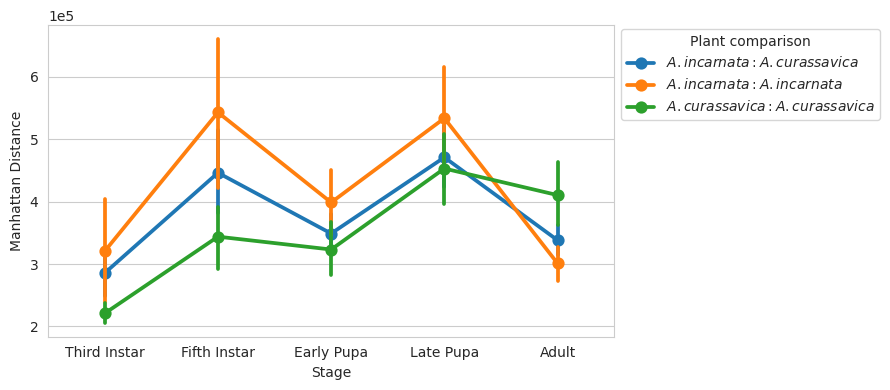

In [13]:
#convert data to long format
manhattan_matrix_long = manhattan_distance_matrix.stack().reset_index()
manhattan_matrix_long.columns = ['comp1', 'comp2', 'manhattan_distance']
manhattan_matrix_long = manhattan_matrix_long[manhattan_matrix_long['comp1'] != manhattan_matrix_long['comp2']]
#parse comparisons
manhattan_data_plantcomp = parse_distance_data_plantcomp(manhattan_matrix_long)

sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(9, 4), sharey=True)
ax = sns.pointplot(data=manhattan_data_plantcomp, y="manhattan_distance", x="stage", hue="plant", ax=ax)

# Italicize legend labels
for text in ax.legend(title='Plant comparison', loc='upper left', bbox_to_anchor=(1, 1.01)).texts:
    text.set_text(f"$\it{{{text.get_text()}}}$")
    
ax.set_ylabel('Manhattan Distance')
plt.xticks(['third-instar', 'fifth-instar', 'early-pupa', 'late-pupa', 'adult'], 
           ['Third Instar', 'Fifth Instar', 'Early Pupa', 'Late Pupa', 'Adult'])

ax.set_xlabel('Stage')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.savefig('/home/gabe/Desktop/mtstp/figures/manhattan_distance_plantcomp_pointplot.pdf')

## Differential gene expression across development

Now I'll do a traditional differential expression analysis using edge R. I like edge R because it seems like its a more conservative approach. The following script was used:

    edgeR_across_development.R

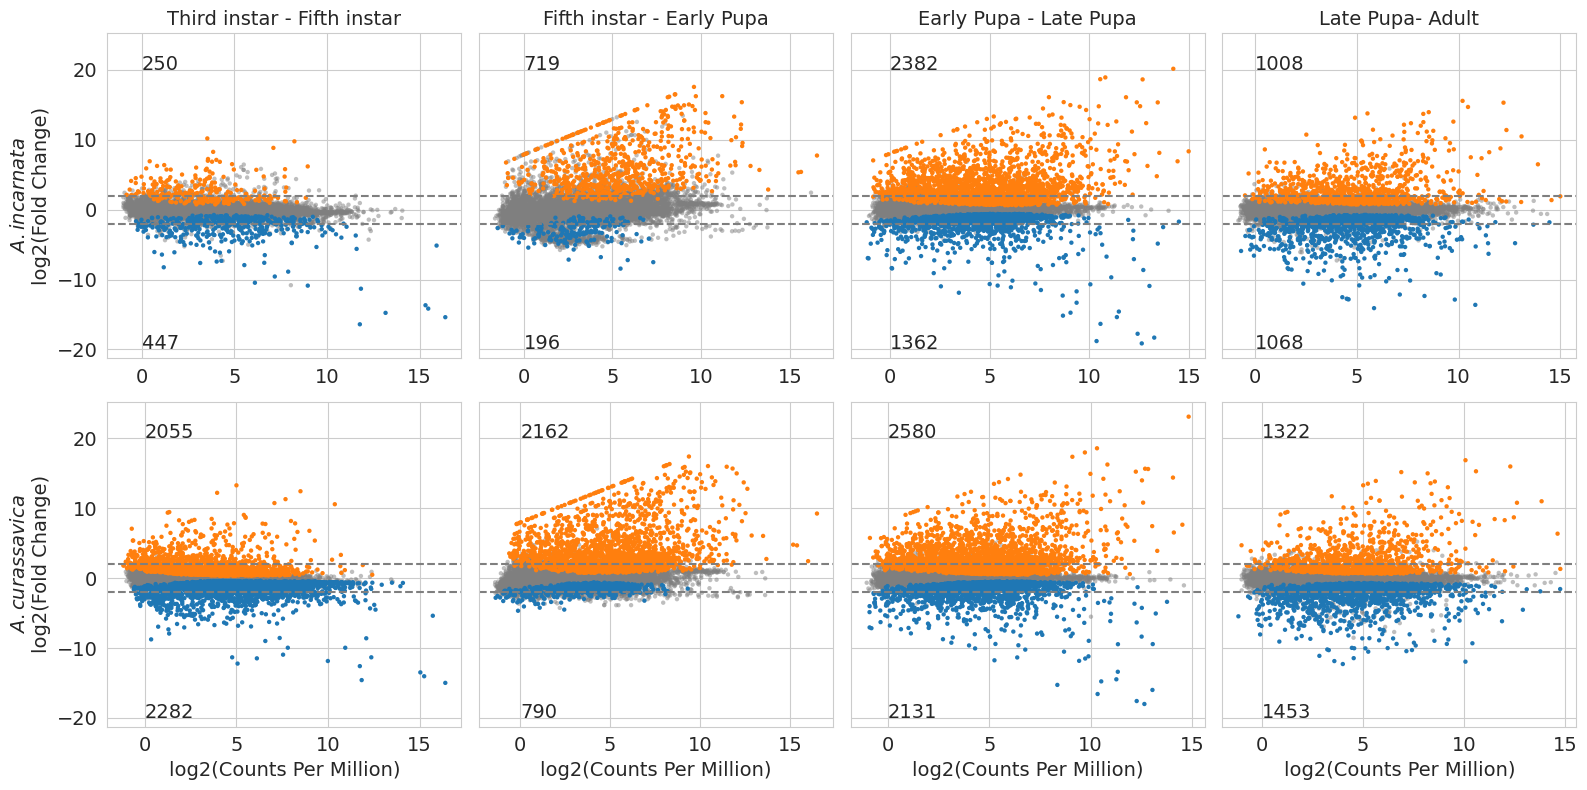

In [14]:
#I want to ignore warnings for plotting. If it works it works
import warnings
warnings.filterwarnings('ignore')

#3-5
third_to_fifth_inc = load_de_data('/home/gabe/Desktop/mtstp/data/intermediate_data/differential_expression/across_development/third_to_fifth_inc_incarnata')
third_to_fifth_cur = load_de_data('/home/gabe/Desktop/mtstp/data/intermediate_data/differential_expression/across_development/third_to_fifth_cur_curassavica')

#5-E
fifth_to_early_inc = load_de_data('/home/gabe/Desktop/mtstp/data/intermediate_data/differential_expression/across_development/fifth_to_early_inc_incarnata')
fifth_to_early_cur = load_de_data('/home/gabe/Desktop/mtstp/data/intermediate_data/differential_expression/across_development/fifth_to_early_cur_curassavica')

#E-L
early_to_late_inc = load_de_data('/home/gabe/Desktop/mtstp/data/intermediate_data/differential_expression/across_development/early_to_late_inc_incarnata')
early_to_late_cur = load_de_data('/home/gabe/Desktop/mtstp/data/intermediate_data/differential_expression/across_development/early_to_late_cur_curassavica')

#E-L
late_to_adult_inc = load_de_data('/home/gabe/Desktop/mtstp/data/intermediate_data/differential_expression/across_development/late_to_adult_inc_incarnata')
late_to_adult_cur = load_de_data('/home/gabe/Desktop/mtstp/data/intermediate_data/differential_expression/across_development/late_to_adult_cur_curassavica')

#get number of up and down regulated genes for each stage
third_to_fifth_inc_up_count = len(third_to_fifth_inc.loc[third_to_fifth_inc['regulation'] == 'up'])
third_to_fifth_inc_down_count = len(third_to_fifth_inc.loc[third_to_fifth_inc['regulation'] == 'down'])
third_to_fifth_cur_up_count = len(third_to_fifth_cur.loc[third_to_fifth_cur['regulation'] == 'up'])
third_to_fifth_cur_down_count = len(third_to_fifth_cur.loc[third_to_fifth_cur['regulation'] == 'down'])

fifth_to_early_inc_up_count = len(fifth_to_early_inc.loc[fifth_to_early_inc['regulation'] == 'up'])
fifth_to_early_inc_down_count = len(fifth_to_early_inc.loc[fifth_to_early_inc['regulation'] == 'down'])
fifth_to_early_cur_up_count = len(fifth_to_early_cur.loc[fifth_to_early_cur['regulation'] == 'up'])
fifth_to_early_cur_down_count = len(fifth_to_early_cur.loc[fifth_to_early_cur['regulation'] == 'down'])

early_to_late_inc_up_count = len(early_to_late_inc.loc[early_to_late_inc['regulation'] == 'up'])
early_to_late_inc_down_count = len(early_to_late_inc.loc[early_to_late_inc['regulation'] == 'down'])
early_to_late_cur_up_count = len(early_to_late_cur.loc[early_to_late_cur['regulation'] == 'up'])
early_to_late_cur_down_count = len(early_to_late_cur.loc[early_to_late_cur['regulation'] == 'down'])

late_to_adult_inc_up_count = len(late_to_adult_inc.loc[late_to_adult_inc['regulation'] == 'up'])
late_to_adult_inc_down_count = len(late_to_adult_inc.loc[late_to_adult_inc['regulation'] == 'down'])
late_to_adult_cur_up_count = len(late_to_adult_cur.loc[late_to_adult_cur['regulation'] == 'up'])
late_to_adult_cur_down_count = len(late_to_adult_cur.loc[late_to_adult_cur['regulation'] == 'down'])

#Make expression plots
sns.set_style('whitegrid')
sns.set_palette("tab10")
size=10

fig, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

#inc first
#plot 3-5
#plot non-regulated
sns.scatterplot(data=third_to_fifth_inc.loc[third_to_fifth_inc["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax1, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=third_to_fifth_inc.loc[third_to_fifth_inc["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax1, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=third_to_fifth_inc.loc[third_to_fifth_inc["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax1, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax1.set_title("Third instar - Fifth instar", size=14)
ax1.set_ylabel('$A. incarnata$\nlog2(Fold Change)', size=14)
ax1.set_xlabel("")
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

#plot 5-E
#plot non-regulated
sns.scatterplot(data=fifth_to_early_inc.loc[fifth_to_early_inc["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax2, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=fifth_to_early_inc.loc[fifth_to_early_inc["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax2, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=fifth_to_early_inc.loc[fifth_to_early_inc["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax2, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)
ax2.set_title("Fifth instar - Early Pupa", size=14)
ax2.set_xlabel("")
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)

#plot E-L
#plot non-regulated
sns.scatterplot(data=early_to_late_inc.loc[early_to_late_inc["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax3, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=early_to_late_inc.loc[early_to_late_inc["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax3, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=early_to_late_inc.loc[early_to_late_inc["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax3, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax3.set_title("Early Pupa - Late Pupa", size=14)
ax3.set_xlabel("")
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)

#plot L-A
#plot non-regulated
sns.scatterplot(data=late_to_adult_inc.loc[late_to_adult_inc["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax4, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=late_to_adult_inc.loc[late_to_adult_inc["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax4, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=late_to_adult_inc.loc[late_to_adult_inc["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax4, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax4.set_title("Late Pupa- Adult", size=14)
ax4.set_xlabel("")
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)

#cur first
#plot 3-5
#plot non-regulated
sns.scatterplot(data=third_to_fifth_cur.loc[third_to_fifth_cur["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax5, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=third_to_fifth_cur.loc[third_to_fifth_cur["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax5, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=third_to_fifth_cur.loc[third_to_fifth_cur["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax5, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax5.set_ylabel('$A. curassavica$\nlog2(Fold Change)', size=14)
ax5.set_xlabel("log2(Counts Per Million)", size=14)
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)

#plot 5-E
#plot non-regulated
sns.scatterplot(data=fifth_to_early_cur.loc[fifth_to_early_cur["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax6, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=fifth_to_early_cur.loc[fifth_to_early_cur["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax6, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=fifth_to_early_cur.loc[fifth_to_early_cur["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax6, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax6.set_xlabel("log2(Counts Per Million)", size=14)
ax6.tick_params(axis='x', labelsize=14)
ax6.tick_params(axis='y', labelsize=14)

#plot E-L
#plot non-regulated
sns.scatterplot(data=early_to_late_cur.loc[early_to_late_cur["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax7, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=early_to_late_cur.loc[early_to_late_cur["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax7, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=early_to_late_cur.loc[early_to_late_cur["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax7, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)


ax7.set_xlabel("log2(Counts Per Million)", size=14)
ax7.tick_params(axis='x', labelsize=14)
ax7.tick_params(axis='y', labelsize=14)

#plot L-A
#plot non-regulated
sns.scatterplot(data=late_to_adult_cur.loc[late_to_adult_cur["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax8, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=late_to_adult_cur.loc[late_to_adult_cur["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax8, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=late_to_adult_cur.loc[late_to_adult_cur["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax8, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax8.set_xlabel("log2(Counts Per Million)", size=14)
ax8.tick_params(axis='x', labelsize=14)
ax8.tick_params(axis='y', labelsize=14)

ax1.text(0, 20, third_to_fifth_inc_up_count, size=14)
ax1.text(0, -20, third_to_fifth_inc_down_count, size=14)
ax2.text(0, 20, fifth_to_early_inc_up_count, size=14)
ax2.text(0, -20, fifth_to_early_inc_down_count, size=14)
ax3.text(0, 20, early_to_late_inc_up_count, size=14)
ax3.text(0, -20, early_to_late_inc_down_count, size=14)
ax4.text(0, 20, late_to_adult_inc_up_count, size=14)
ax4.text(0, -20, late_to_adult_inc_down_count, size=14)
ax5.text(0, 20, third_to_fifth_cur_up_count, size=14)
ax5.text(0, -20, third_to_fifth_cur_down_count, size=14)
ax6.text(0, 20, fifth_to_early_cur_up_count, size=14)
ax6.text(0, -20, fifth_to_early_cur_down_count, size=14)
ax7.text(0, 20, early_to_late_cur_up_count, size=14)
ax7.text(0, -20, early_to_late_cur_down_count, size=14)
ax8.text(0, 20, late_to_adult_cur_up_count, size=14)
ax8.text(0, -20, late_to_adult_cur_down_count, size=14)

ax1.axhline(2, color='tab:gray', linestyle ="--")
ax1.axhline(-2, color='tab:gray', linestyle ="--")
ax2.axhline(2, color='tab:gray', linestyle ="--")
ax2.axhline(-2, color='tab:gray', linestyle ="--")
ax3.axhline(2, color='tab:gray', linestyle ="--")
ax3.axhline(-2, color='tab:gray', linestyle ="--")
ax4.axhline(2, color='tab:gray', linestyle ="--")
ax4.axhline(-2, color='tab:gray', linestyle ="--")
ax5.axhline(2, color='tab:gray', linestyle ="--")
ax5.axhline(-2, color='tab:gray', linestyle ="--")
ax6.axhline(2, color='tab:gray', linestyle ="--")
ax6.axhline(-2, color='tab:gray', linestyle ="--")
ax7.axhline(2, color='tab:gray', linestyle ="--")
ax7.axhline(-2, color='tab:gray', linestyle ="--")
ax8.axhline(2, color='tab:gray', linestyle ="--")
ax8.axhline(-2, color='tab:gray', linestyle ="--")

plt.tight_layout()
plt.savefig('/home/gabe/Desktop/mtstp/figures/dges_across_development.pdf')

## Differential gene expression by plant

There doesn't seem to be many differences by plant, but it could be good to keep quantifications consistent.
To get differential gene expression between plants at each stage:

    edger_infected_vs_uninfected_by_plant.R
    
To as usual, I'll ignore the infected ones.

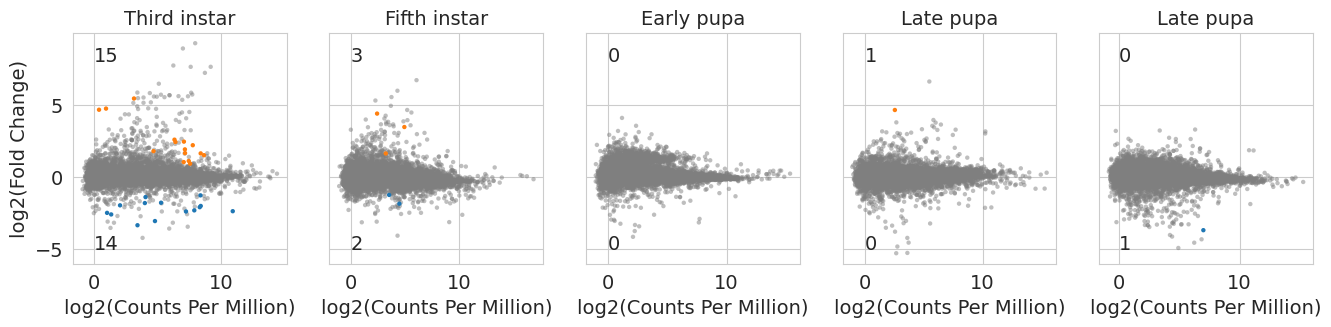

In [36]:
import warnings
warnings.filterwarnings('ignore')

#load data
third_c_vs_i = load_de_data('/home/gabe/Desktop/mtstp/data/intermediate_data/differential_expression/incarnata_vs_curassavica_by_infection/third_instar_cur_vs_inc_uninfected')
fifth_c_vs_i = load_de_data('/home/gabe/Desktop/mtstp/data/intermediate_data/differential_expression/incarnata_vs_curassavica_by_infection/fifth_instar_cur_vs_inc_uninfected')
early_c_vs_i = load_de_data('/home/gabe/Desktop/mtstp/data/intermediate_data/differential_expression/incarnata_vs_curassavica_by_infection/early_pupa_cur_vs_inc_uninfected')
late_c_vs_i = load_de_data('/home/gabe/Desktop/mtstp/data/intermediate_data/differential_expression/incarnata_vs_curassavica_by_infection/late_pupa_cur_vs_inc_uninfected')
adult_c_vs_i = load_de_data('/home/gabe/Desktop/mtstp/data/intermediate_data/differential_expression/incarnata_vs_curassavica_by_infection/adult_cur_vs_inc_uninfected')

#get number of up and down regulated genes for each stage
third_c_vs_i_up_count = len(third_c_vs_i.loc[third_c_vs_i['regulation'] == 'up'])
third_c_vs_i_down_count = len(third_c_vs_i.loc[third_c_vs_i['regulation'] == 'down'])

fifth_c_vs_i_up_count = len(fifth_c_vs_i.loc[fifth_c_vs_i['regulation'] == 'up'])
fifth_c_vs_i_down_count = len(fifth_c_vs_i.loc[fifth_c_vs_i['regulation'] == 'down'])

early_c_vs_i_up_count = len(early_c_vs_i.loc[early_c_vs_i['regulation'] == 'up'])
early_c_vs_i_down_count = len(early_c_vs_i.loc[early_c_vs_i['regulation'] == 'down'])

late_c_vs_i_up_count = len(late_c_vs_i.loc[late_c_vs_i['regulation'] == 'up'])
late_c_vs_i_down_count = len(late_c_vs_i.loc[late_c_vs_i['regulation'] == 'down'])

adult_c_vs_i_up_count = len(adult_c_vs_i.loc[adult_c_vs_i['regulation'] == 'up'])
adult_c_vs_i_down_count = len(adult_c_vs_i.loc[adult_c_vs_i['regulation'] == 'down'])

#Make expression plots
sns.set_style('whitegrid')
sns.set_palette("tab10")
size=10

fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(1, 5, figsize=(16, 3), sharey=True)

#3rd
#plot non-regulated
sns.scatterplot(data=third_c_vs_i.loc[third_c_vs_i["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax1, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=third_c_vs_i.loc[third_c_vs_i["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax1, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=third_c_vs_i.loc[third_c_vs_i["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax1, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax1.set_title("Third instar", size=14)
ax1.set_ylabel('log2(Fold Change)', size=14)
ax1.set_xlabel("")
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

#5th
#plot non-regulated
sns.scatterplot(data=fifth_c_vs_i.loc[fifth_c_vs_i["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax2, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=fifth_c_vs_i.loc[fifth_c_vs_i["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax2, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=fifth_c_vs_i.loc[fifth_c_vs_i["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax2, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax2.set_title("Fifth instar", size=14)
ax2.set_ylabel('log2(Fold Change)', size=14)
ax2.set_xlabel("")
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)

#Early
#plot non-regulated
sns.scatterplot(data=early_c_vs_i.loc[early_c_vs_i["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax3, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=early_c_vs_i.loc[early_c_vs_i["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax3, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=early_c_vs_i.loc[early_c_vs_i["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax3, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax3.set_title("Early pupa", size=14)
ax3.set_ylabel('log2(Fold Change)', size=14)
ax3.set_xlabel("")
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)

#Late
#plot non-regulated
sns.scatterplot(data=late_c_vs_i.loc[late_c_vs_i["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax4, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=late_c_vs_i.loc[late_c_vs_i["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax4, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=late_c_vs_i.loc[late_c_vs_i["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax4, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax4.set_title("Late pupa", size=14)
ax4.set_ylabel('log2(Fold Change)', size=14)
ax4.set_xlabel("")
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)

#Adult
#plot non-regulated
sns.scatterplot(data=adult_c_vs_i.loc[adult_c_vs_i["regulation"] == "NA"], 
                x="logCPM", y="logFC", ax=ax5, edgecolor = 'none', color = "tab:gray", alpha=0.5, s=size)
#plot up regulated
sns.scatterplot(data=adult_c_vs_i.loc[adult_c_vs_i["regulation"] == "up"], 
                x="logCPM", y="logFC", ax=ax5, edgecolor = 'none', color = "tab:orange", alpha=1, s=size)
#plot down regulated
sns.scatterplot(data=adult_c_vs_i.loc[adult_c_vs_i["regulation"] == "down"], 
                x="logCPM", y="logFC", ax=ax5, edgecolor = 'none', color = "tab:blue", alpha=1, s=size)

ax5.set_title("Late pupa", size=14)
ax5.set_ylabel('log2(Fold Change)', size=14)
ax5.set_xlabel("")
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)

ax1.text(0, 8, third_c_vs_i_up_count, size=14)
ax1.text(0, -5, third_c_vs_i_down_count, size=14)
ax2.text(0, 8, fifth_c_vs_i_up_count, size=14)
ax2.text(0, -5, fifth_c_vs_i_down_count, size=14)
ax3.text(0, 8, early_c_vs_i_up_count, size=14)
ax3.text(0, -5, early_c_vs_i_down_count, size=14)
ax4.text(0, 8, late_c_vs_i_up_count, size=14)
ax4.text(0, -5, late_c_vs_i_down_count, size=14)
ax5.text(0, 8, adult_c_vs_i_up_count, size=14)
ax5.text(0, -5, adult_c_vs_i_down_count, size=14)

ax1.set_xlabel("log2(Counts Per Million)", size=14)
ax2.set_xlabel("log2(Counts Per Million)", size=14)
ax3.set_xlabel("log2(Counts Per Million)", size=14)
ax4.set_xlabel("log2(Counts Per Million)", size=14)
ax5.set_xlabel("log2(Counts Per Million)", size=14)

plt.savefig('/home/gabe/Desktop/mtstp/figures/dges_by_plant.pdf')

### Functional summary

In [4]:
#The origional KEGG brite JSON file is structured in a way that will be difficult to work with.
#I'd basically need to use a non-uniform tree traversal algorithm to get the functional herirarchies I 
#need for each gene, which would probably take a really long time. Instead, I added a function to gnat that 
#parses a KEGG BRITE JSON file and returns the heirarchy information in a format that allows you to querry
#gene ids (GenBank).

dpl_kegg_dict = kegg_tools.parse_brite_json('/home/gabe/Desktop/mtstp/data/intermediate_data/dpl00001.json')

#and I guess I'll show what this looks for one gene id (for documntation purposes)
dpl_kegg_dict['KGM_209159']

[{'ko_number': 'K00844',
  'description_1': 'Hexokinase',
  'description_2': 'hexokinase [EC:2.7.1.1]',
  'functional_heirarcy': {'functional_group_level1': 'Metabolism',
   'functional_group_level2': 'Carbohydrate metabolism',
   'functional_group_level3': 'Glycolysis / Gluconeogenesis'}},
 {'ko_number': 'K00844',
  'description_1': 'Hexokinase',
  'description_2': 'hexokinase [EC:2.7.1.1]',
  'functional_heirarcy': {'functional_group_level1': 'Metabolism',
   'functional_group_level2': 'Carbohydrate metabolism',
   'functional_group_level3': 'Fructose and mannose metabolism'}},
 {'ko_number': 'K00844',
  'description_1': 'Hexokinase',
  'description_2': 'hexokinase [EC:2.7.1.1]',
  'functional_heirarcy': {'functional_group_level1': 'Metabolism',
   'functional_group_level2': 'Carbohydrate metabolism',
   'functional_group_level3': 'Galactose metabolism'}},
 {'ko_number': 'K00844',
  'description_1': 'Hexokinase',
  'description_2': 'hexokinase [EC:2.7.1.1]',
  'functional_heirarcy': 

In [5]:
#since the gene ids in my counts matrix are in the standard Genbank CDS FASTA format, I need to 
#be able to get gene ids from protein ids inorder to cross reference to the kegg dictionary. So I just added a 
#function to gnat to make this nice and easy

protein_to_gene_dict = gtf_tools.get_gene_protein_id_dictionary('/home/gabe/Desktop/mtstp/data/intermediate_data/dpl_genes.gtf')


In [10]:
#I'll start with the highest functional level and go from there

#initialize dataframe
function_level1_df = pd.DataFrame(index=uninfected_data.index)

#list of groups to exclude
exclude = ['Human Diseases', 'Brite Hierarchies', 'Not Included in Pathway or Brite']

#iterate through gene ids
for gene_id in list(uninfected_data.columns):
    protein_id = gene_id.split('_')[2]
    gbid = protein_to_gene_dict[protein_id]
    
    #get function
    if gbid in dpl_kegg_dict:
        functions = dpl_kegg_dict[gbid]
    
        function_level_1_groups = []
        #get functionl level 1
        for function in functions:
            functional_heirarchy = function['functional_heirarcy']
            #just realized I mispelled heirarchy. Ohh well
            if functional_heirarchy['functional_group_level1'] not in function_level_1_groups:
                if functional_heirarchy['functional_group_level1'] not in exclude:
                    function_level_1_groups.append(functional_heirarchy['functional_group_level1'])
        
        #I'm not certain what the best way to handle genes that are involved in multiple functions is
        #If a gene is involved in multiple functions, we can't really tell which functions it's doing.
        #one option is to count it for both categories, and the other option is to exclude it all together.
        #I think excluding it is the best way. My overall question is just to get a general sense of 
        #what processes the organism is investing in across development, so if the signal is strong,
        #it should hold even if multi-purpus genes are removed. For now, I'll include everything that doesn't
        #map to a single pathway in an "Ambiguous" category
        if len(function_level_1_groups) == 1:
            functional_class = function_level_1_groups[0]
            #if function is not alread in dataframe, add it with empty 0s
            if functional_class not in list(function_level1_df.columns):
                function_level1_df[functional_class] = np.zeros(len(function_level1_df.index), dtype=int)
            
            #add values to appropriate column
            function_level1_df[functional_class] = function_level1_df[functional_class] + uninfected_data[gene_id]

In [11]:
#now I need to add metadata
plant = []
developmental_stage = []

for sample in list(function_level1_df.index):
    plant_type = sample[6]
    stage = sample[5]
    
    if plant_type == 'c':
        plant.append('A. curassavica')
    elif plant_type == 'i':
        plant.append('A. incarnata')
    
    if stage == '3':
        developmental_stage.append('3rd-instar')
    elif stage == '5':
        developmental_stage.append('5th-instar')
    elif stage == 'E':
        developmental_stage.append('Early-pupa')
    elif stage == 'L':
        developmental_stage.append('Late-pupa')
    elif stage == 'A':
        developmental_stage.append('Adult')

#add metadata to dataframe

function_level1_df['plant'] = plant
function_level1_df['developmental_stage'] = developmental_stage

In [12]:
#sort data by transition order
dev_order = ['3rd-instar', '5th-instar', 'Early-pupa', 'Late-pupa', 'Adult']
function_level1_df['developmental_stage'] = pd.Categorical(function_level1_df['developmental_stage'], categories = dev_order)
function_level1_df = function_level1_df.sort_values(by='developmental_stage')

In [13]:
#and now I'll show the new data frame, for documentation
function_level1_df

,Metabolism,Cellular Processes,Genetic Information Processing,Environmental Information Processing,Organismal Systems,plant,developmental_stage
sample-id,,,,,,,
mtstp3iu81,90294.068590,30865.450640,236779.060348,18236.014952,2488.076242,A. incarnata,3rd-instar
mtstp3cu2,85606.762960,31416.481161,236164.910932,18082.581320,2573.624664,A. curassavica,3rd-instar
mtstp3iu85,77381.554456,25586.694823,223882.133121,11995.771395,2148.823108,A. incarnata,3rd-instar
mtstp3cu5,88154.139730,32088.457610,240499.900138,17122.292679,2526.259031,A. curassavica,3rd-instar
mtstp3cu4,87167.873196,28790.809674,232435.833189,15933.343704,2292.769284,A. curassavica,3rd-instar
mtstp3cu3,86596.681008,29906.394452,228323.338437,15476.393891,2295.069344,A. curassavica,3rd-instar
mtstp3cu8,82331.247272,32259.361854,262466.807959,18007.400088,2558.134118,A. curassavica,3rd-instar
mtstp3iu83,88598.873919,29738.449203,230692.595211,16558.944091,2451.947609,A. incarnata,3rd-instar
mtstp3iu82,81378.598278,32025.681059,242645.807914,15730.937375,2505.916957,A. incarnata,3rd-instar


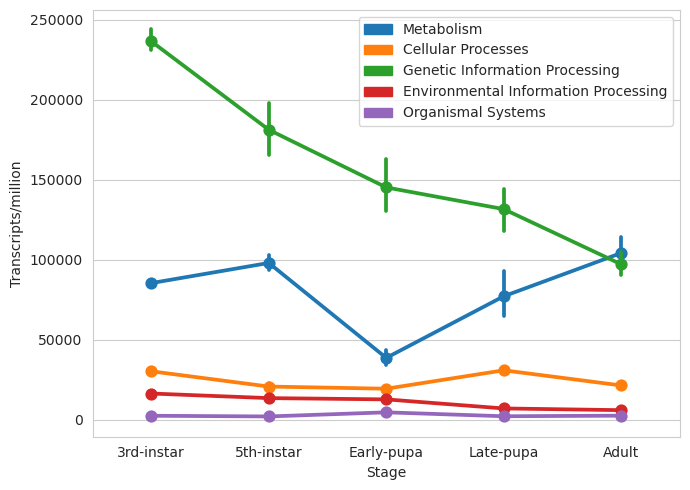

In [25]:
processes = list(function_level1_df.columns)[0:-2]

sns.set_style('whitegrid')
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5), sharey=True)

#define colors
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
#plot incarnata
for i in range(len(processes)):
    process = processes[i]
    sns.pointplot(data=function_level1_df, x='developmental_stage', y=process, ax=ax1, color=colors[i])


ax1.set_ylabel('Transcripts/million')
ax1.set_xlabel('Stage')


    

plt.legend(handles=legend_cols, bbox_to_anchor=(1,1,0,0))

plt.tight_layout()
plt.savefig('/home/gabe/Desktop/mtstp/figures/supplement/function_stuff.pdf')